In [1]:
from typing import List, Optional, Tuple, Union

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st

import utils as u
from models import morales2009, pentzer2014pow, pentzer2022
from steps import preprocess
from visualization import papermode

papermode(plt, size=15)


In [2]:
def abbrange(letter:str, a:int, b:int)->Tuple[str]:
    return (f"{letter}{i:02}" for i in range(a,b))

In [3]:
d_abbrs = (*abbrange("D", 1, 7), "D09", "D11", "D12", "D13", "D14", "D16", *abbrange("D", 18, 23))
m_abbrs = abbrange("M", 1, 8)
r_abbrs = ("R02", "R03", "R07", "R08", "R09", "R10", "R12", "R14")
p_abbrs = abbrange("P", 1, 11)
s_abbrs = (*abbrange("S", 1, 11), "S21", "S22", "S23", "S28", "S29", "S30", "S31")
t_abbrs = ("TA", "TB", "TC")

abbrs = (
    *m_abbrs,
    *r_abbrs,
    *p_abbrs,
    *abbrange("D", 1, 3),
    # *d_abbrs,
    # *s_abbrs,
    # *t_abbrs,
)


In [4]:
colors = u.COLORS
cols = {a: colors[u.get_terrain(a)] for a in abbrs}
terrains = sorted(set(u.get_terrain(a) for a in abbrs))
terr_cols = {terr: colors[terr] for terr in terrains}

# Simple labels
splabs = u.COLORS


def add_terrain_legend(
    mpl_elem: Union[mpl.axes.Axes, mpl.figure.Figure],
    highlighted: Optional[List[str]] = None,
    layout: str = "vertical",
):
    legend_handles = [mpatches.Patch(color=col, label=lab.title()) for lab, col in terr_cols.items()]
    if highlighted is not None:
        legend_handles.extend([mpatches.Patch(color="xkcd:bright red", label=lab) for lab in highlighted])
    # mpl_elem.legend(handles=legend_handles, bbox_to_anchor=(1.05, 0), loc="lower left")
    if layout.lower == "vertical":
        mpl_elem.legend(
            handles=legend_handles,
            bbox_to_anchor=(1, 0.5),
            loc="center left",
            title="Terrain",
        )
    else:
        mpl_elem.legend(
            handles=legend_handles,
            ncol=len(colors),
            bbox_to_anchor=(0.5, -0.03),
            loc="upper center",
            title="Terrain",
        )


In [5]:
p2022_dfs = {}
for abbr in abbrs:
    preprocess(abbr, verbose=False)
    p2022df = pentzer2022.pentzer2022(abbr, verbose=False);
    p2022_dfs[abbr] = p2022df


D02: 100%|██████████| 846/846 [00:00<00:00, 5300.85it/s]


# Pentzer 2022

In [6]:
model_name = pentzer2022.__MODEL_NAME__.lower()
figdir = u.get_figdir("thesis", subdir=f"modeling/distribution-{model_name}")

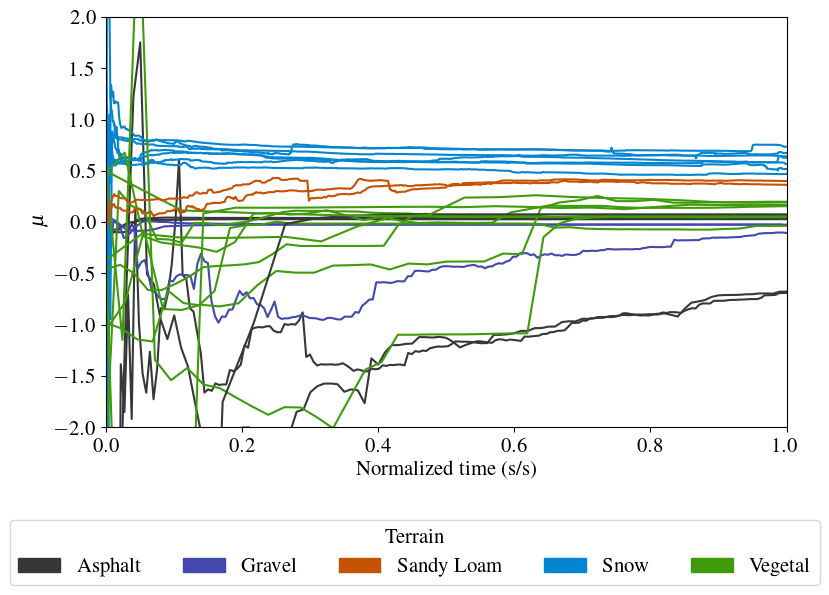

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))

for abbr in abbrs:
    col = cols[abbr]
    ax.plot(p2022_dfs[abbr].time_prop, p2022_dfs[abbr].m_sym, col, label=abbr)
ax.set_ylim(bottom=-2, top=2)
ax.set_xlim(left=0, right=1)
add_terrain_legend(fig, layout="horizontal")
ax.set_xlabel("Normalized time (s/s)")
ax.set_ylabel("$\mu$")

fig.tight_layout()

for ext in u.EXTS:
    fig.savefig(figdir / f"{model_name}-mu.{ext}", bbox_inches="tight")

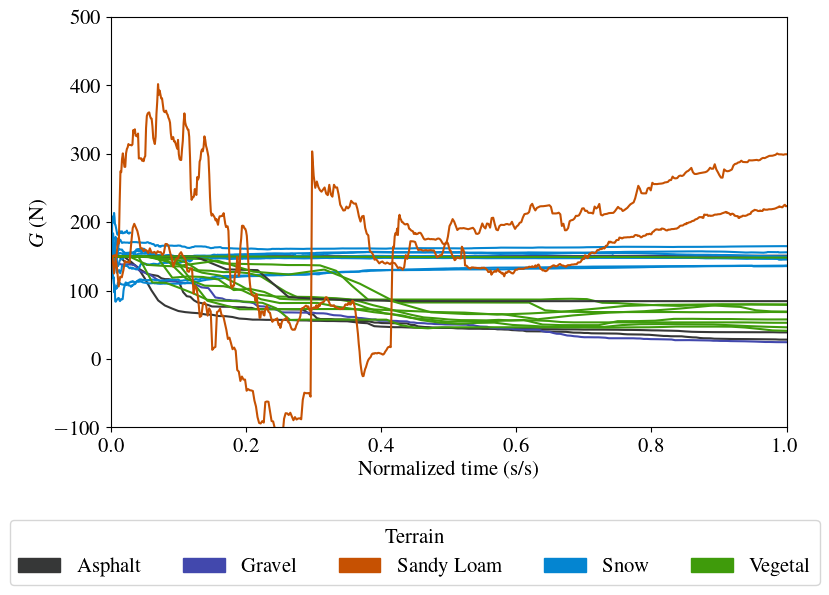

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))

for abbr in abbrs:
    col = cols[abbr]
    ax.plot(p2022_dfs[abbr].time_prop, p2022_dfs[abbr].G_sym, col, label=abbr)
ax.set_ylim(bottom=-100, top=500)
ax.set_xlim(left=0, right=1)
add_terrain_legend(fig)
ax.set_xlabel("Normalized time (s/s)")
ax.set_ylabel("$G$ (N)")

fig.tight_layout()

for ext in u.EXTS:
    fig.savefig(figdir / f"{model_name}-G.{ext}", bbox_inches="tight")

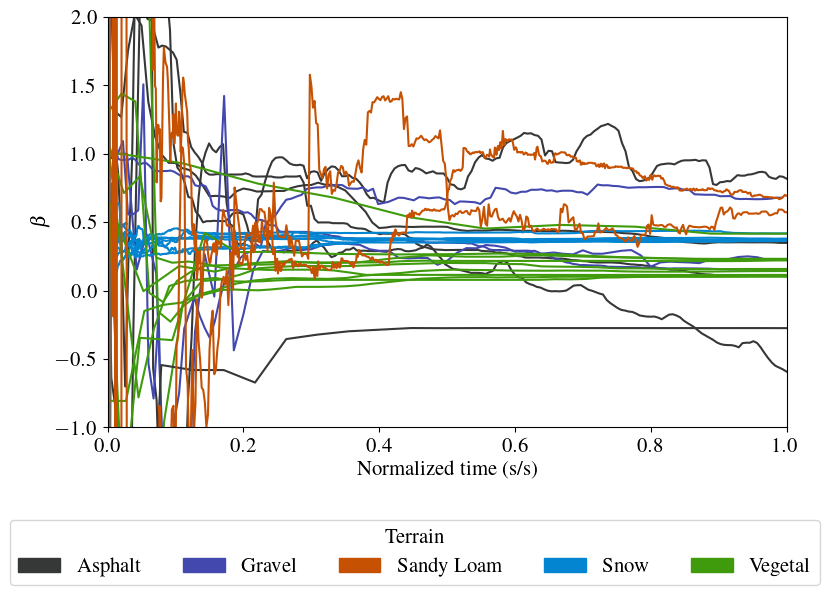

In [9]:
fig, ax = plt.subplots(figsize=(8, 5))

for abbr in abbrs:
    col = cols[abbr]
    ax.plot(p2022_dfs[abbr].time_prop, p2022_dfs[abbr].B_sym, col, label=abbr)
ax.set_ylim(bottom=-1, top=2)
ax.set_xlim(left=0, right=1)
add_terrain_legend(fig)
ax.set_xlabel("Normalized time (s/s)")
ax.set_ylabel("$\\beta$")

fig.tight_layout()

for ext in u.EXTS:
    fig.savefig(figdir / f"{model_name}-b.{ext}", bbox_inches="tight")

# Distribution

In [10]:
abbrs_dict = [{"abbr":a, "terrain":u.get_terrain(a)} for a in abbrs]
mu_df = pd.DataFrame(abbrs_dict)
model_values = u.model_subset_from_json(abbrs, pentzer2022.__MODEL_NAME__)
# mu_df["mu"] = mu_df.abbr.apply(lambda x: model_values[x]["coefficients"]["m_sym"]["last"])
mu_df["mu"] = mu_df.abbr.apply(lambda x: p2022_dfs[x].m_sym.dropna().iloc[-int(len(p2022_dfs[x].index)/6):].to_numpy())

In [11]:
terrains = [
    "gravel",
    "asphalt",
    "vegetal",
    "sandy loam",
    "snow",
]
y_data = [np.concatenate(mu_df[mu_df.terrain == terr].mu.values) for terr in terrains]

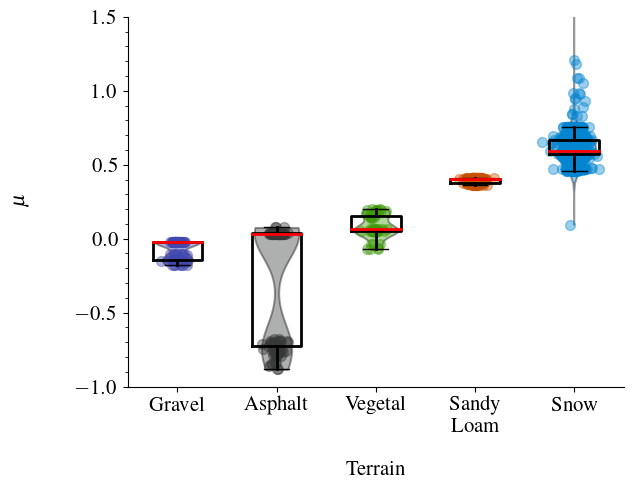

In [12]:
jitter = 0.04
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]

x_pos = [*range(len(y_data))]

medianprops = dict(
    linewidth=2,
    color="r",
)
boxprops = dict(linewidth=2, color="k")

fig, ax = plt.subplots()
violins = ax.violinplot(
    y_data,
    positions=x_pos,
    widths=0.45,
    bw_method="silverman",
    showmeans=False,
    showmedians=False,
    showextrema=False,
)

for pc, terr in zip(violins["bodies"], terrains):
    pc.set_facecolor(colors[terr])
    pc.set_edgecolor("k")
    pc.set_linewidth(1.4)
    pc.set_alpha(0.4)

ax.boxplot(
    y_data,
    positions=x_pos,
    showfliers=False,
    showcaps=True,  # Do not show the caps
    medianprops=medianprops,
    whiskerprops=boxprops,
    boxprops=boxprops,
)

for x, y, terr in zip(x_jittered, y_data, terrains):
    ax.scatter(x, y, s=50, color=colors[terr], alpha=0.4)

xlabels = [terr.title() for terr in terrains]
xlabels[3] = "\n".join(xlabels[3].split(" "))
ax.set_xticks(x_pos)
ax.set_xticklabels(xlabels)

ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.set_ylabel("$\mu$")
ax.yaxis.set_label_coords(-0.2, 0.5)
ax.set_xlabel("Terrain")
ax.xaxis.set_label_coords(0.5, -0.2)

ax.set_ylim(bottom=-1, top=1.5)

for ext in u.EXTS:
    fig.savefig(figdir / f"{model_name}_mbplot.{ext}", bbox_inches="tight")


In [13]:
" ".join(abbrs)

'M01 M02 M03 M04 M05 M06 M07 R02 R03 R07 R08 R09 R10 R12 R14 P01 P02 P03 P04 P05 P06 P07 P08 P09 P10 D01 D02'

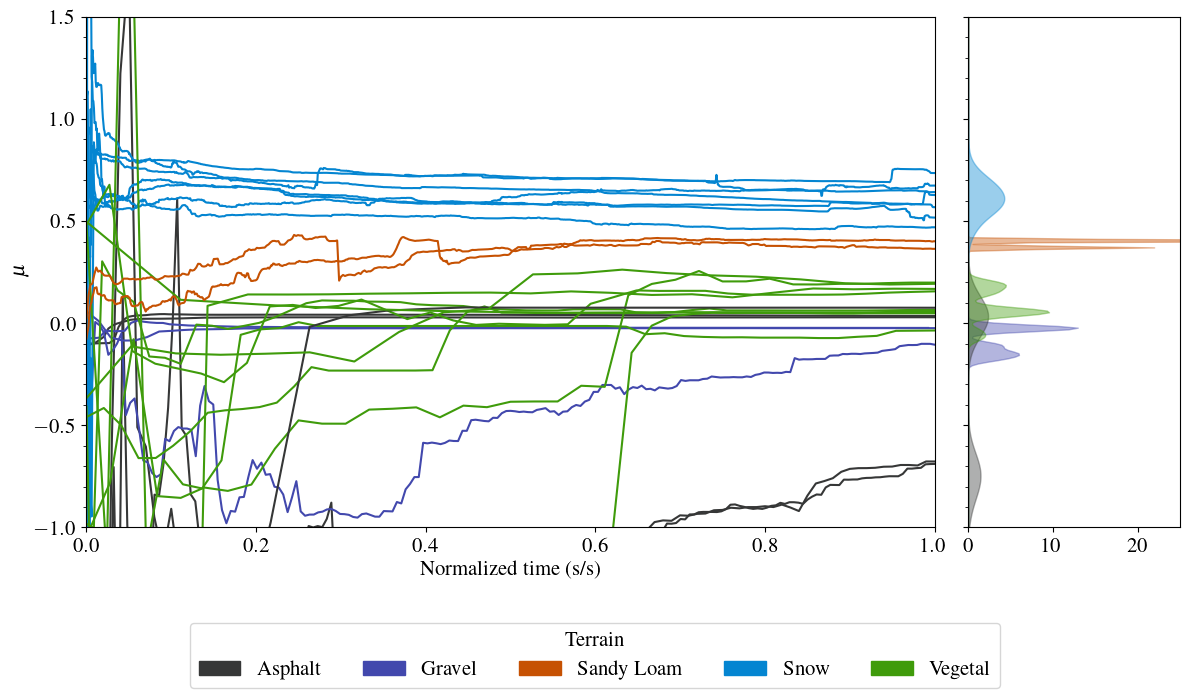

In [14]:
fig, [ax1, ax2] = plt.subplots(figsize=(12,6), ncols=2, gridspec_kw={'width_ratios': [4, 1]}, sharey=True)

for abbr in abbrs:
    col = cols[abbr]
    ax1.plot(p2022_dfs[abbr].time_prop, p2022_dfs[abbr].m_sym, col, label=abbr)
ax1.set_ylim(bottom=-1, top=1.5)
ax1.set_xlim(left=0, right=1)
add_terrain_legend(fig)
ax1.set_xlabel("Normalized time (s/s)")
ax1.set_ylabel("$\mu$")

ax2.set_xlim(left=0, right=25)
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
fig.tight_layout()

ys = np.linspace(*ax2.get_ylim(), num=300)

for terr, terr_mu in zip(terrains, y_data):
    terr_col = colors[terr]

    density = st.gaussian_kde(terr_mu)
    density.covariance_factor = lambda: .25
    density._compute_covariance()

    ax2.fill_betweenx(ys, density(ys), color=terr_col, alpha=0.4)

for ext in u.EXTS:
    fig.savefig(figdir / f"{model_name}_mdist.{ext}", bbox_inches="tight")